In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import math
from sklearn.datasets import load_iris
from scipy import stats

from sklearn.naive_bayes import GaussianNB

# **Question 1, Number 3**

d-fold cross-validation means we use d subsets of data to get the value of k.
If the dataset is split into training data and testing data in the ratio of 80:20, we have 80% of data in training data(D_Train). We further randomly split the training data into 4 equal parts(D1, D2, D3, D4). 

By keeping one of the datasets as a cross-validation dataset and train the model using the remaining datasets for different values of k and find the best value of k.
Here's how to select k value using d-fold cross-validation. It's usually called k-fold, but we're using k to talk about the number of neighbors.

1. Split the data into d disjoint, similarly-sized subsets
2. Hold out the first set. This is called the validation set.
3. Train your classifier on the remaining data. In the case of knn classification, just remember all the data.
4. For each value of k:
    - Classify each point in the validation set, using its k nearest neighbors in the training set
    - Record the accuracy
5. Repeat steps 1-4 for all d choices of the validation set.
6. For each choice of k, find the average accuracy across validation sets. Choose the value of k with the highest accuracy.
7. Construct a final classifier using all of the original data and the chosen value of k. This is what you'd use to classify new points.

Only one drawback of using cross-validation is we are repeating computations for every k. In spite of having high time complexity, the process is worth it as it increases the generalization of the model.

# **2**

My final model: y = 2.1434 + 3.7737 x1 + -2.5566 x2
Co-efficients from skLearn theta1 = 69.7372, theta2 = -30.9021 
Intercept from skLearn = 49.2632 


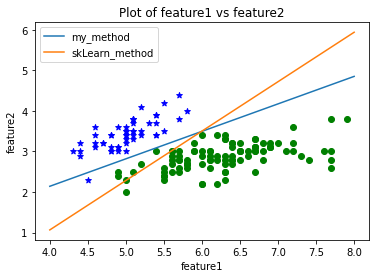

In [605]:
def logisticRegression(learn_rate, num_iter):
    # Read in data, ignore first row (header info) and first column (index info)
    iris = load_iris()
    X = iris.data[ : , :2]
    y = (iris.target!= 0) * 1
    
    num_rows, num_cols = X.shape
    
    # Get the mean and standard deviation
    mean = X.mean(axis=0)
    std = np.std(X, axis=0, ddof=1)
    
    #Standadized train and test X vector with bias
    sXNoBias = (X - mean)/std    
    sX = np.column_stack((np.ones(num_rows), sXNoBias))

    #Initialize the parameters of theta using random values in the range [-1,1]
    theta = np.random.uniform(low=-1, high=1,size=(num_cols+1)).reshape(((num_cols+1)),1)
#     theta = [ [0.02864473], [-0.70407966], [-0.05586018]]

    finalNumIter = 0
    y = y.reshape(num_rows, 1)

#     terminate when abs val in percent chage in loss on the data is < 2^-23 or num_iter iterations
    allLosses = []
    for i in range(num_iter):
        finalNumIter += 1
        init = (sX @ theta)
        expInit = np.exp(-init)
        sigmoid = 1/(1 + expInit)
        inBracket = sigmoid - y
        rhs = (sX.T @ inBracket)
        theta = theta - ((learn_rate * rhs)/num_rows)
        yHat = sX @ theta
        loss = (yHat * np.log(sigmoid)) + ((1-yHat) * np.log(1-sigmoid))
        loss = loss.sum(axis=0)
        allLosses.append(loss)
        
        #if need to stop for RMSE train percent change less than 2^-23
        if i < 2:
            #For empty loss function array
            continue
        else:
            lossLen = len(allLosses)
            diff = allLosses[lossLen-1] - allLosses[lossLen-2] #new - old
            incr = abs((diff/allLosses[lossLen-2]) * 100)
            compr = 2 ** -23
            if incr < compr:
                break
  
    #Final thetas
    print("My final model: y = %.4f + %.4f x1 + %.4f x2" %(theta[0], theta[1], theta[2]))
    lgr = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
    y = (iris.target!= 0) * 1
    lgr.fit(sXNoBias,y)
    print("Co-efficients from skLearn theta1 = %.4f, theta2 = %.4f " %(lgr.coef_[0][0], lgr.coef_[0][1]))
    print("Intercept from skLearn = %.4f " %(lgr.intercept_[0]))
    
#     x_something is feature 1
    feature2 = X[:,1]
    x_mine = -(theta[0]/theta[1])-((theta[2]/theta[1])*4)
    x_mine_2 = -(theta[0]/theta[1])-((theta[2]/theta[1])*8)
    
    
    x_logistic = -(lgr.intercept_[0]/lgr.coef_[0][0])-((lgr.coef_[0][1]/lgr.coef_[0][0])*4)
    x_logistic_2 = -(lgr.intercept_[0]/lgr.coef_[0][0])-((lgr.coef_[0][1]/lgr.coef_[0][0])*15)
    
    #x-axis = feature 1 and y-axis = feature 2
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', marker='*')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='g', marker='o')
        
    plt.plot([4, 8],[x_mine, x_mine_2],label="my_method")   
    plt.plot([4, 8],[x_logistic, x_logistic_2], label="skLearn_method")   
    plt.xlabel('feature1')
    plt.ylabel('feature2')

    plt.title("Plot of feature1 vs feature2")
    plt.legend()

logisticRegression(0.01, 10000)


# **3**

In [611]:
def LogisticRegressionSpam(filename,learn_rate, num_iter):
    # Read in data, ignore first row (header info) and first column (index info)
    df = pd.read_csv(filename, header=None)

    num_rows, num_cols = df.shape
    
    # Randomize the data (Gives the same data everytime)
    df = df.sample(n = num_rows, random_state=0)
    
    # Select 2/3 of the data for training and the rest for testing
    train = df.sample(frac=0.667, random_state=0)
    test = df.drop(train.index)
    
    # Standadize the data... Make sure you retain the mean and standard deviation
    mean = np.mean(df).iloc[:-1]
    std = np.std(df, axis=0, ddof=1).iloc[:-1]
    trainXVec = train.iloc[: , :-1] #X-vector train
    testXVec = test.iloc[: , :-1] #X-vector test
    trainYVec = train.iloc[: , -1:] #Y-vector train
    testYVec = test.iloc[: , -1:] #Y-vector test
    sTrainXVec = (trainXVec - mean)/std    
    sTestXVec = (testXVec - mean)/std
    sTrainNoBias = sTrainXVec
    sTrainXVec.insert(0,'Bias',1)
    sTestXVec.insert(0,'Bias',1)
    num_rows_train, num_cols_train = sTrainXVec.shape
    num_rows_test, num_cols_train = sTestXVec.shape
    
    
    #Initialize the parameters of theta using random values in the range [-1,1]
    theta = np.random.uniform(low=-1, high=1,size=(num_cols)).reshape(((num_cols)),1)
    finalNumIter = 0
    
    small_random_number = np.finfo(float).eps

#     terminate when abs val in percent chage in loss on the data is < 2^-23 or num_iter iterations
    allLosses = []
    for i in range(num_iter):
        finalNumIter += 1
        init = (sTrainXVec @ theta)
        expInit = np.exp(-init)
        sigmoid = (1/(1 + expInit))
        inBracket = np.array(sigmoid) - np.array(trainYVec)
        rhs = (sTrainXVec.T @ inBracket)
        theta = theta - ((learn_rate * rhs)/num_rows_train)
        yHat = sTrainXVec @ theta
        loss = (yHat * np.log(sigmoid + small_random_number)) + ((1-yHat) * np.log(1-sigmoid + small_random_number))
        loss = loss.sum(axis=0)
        allLosses.append(loss)
        
        #if need to stop for loss percent change less than 2^-23
        if i < 2:
            #For empty loss function array
            continue
        else:
            lossLen = len(allLosses)
            diff = allLosses[lossLen-1] - allLosses[lossLen-2] #new - old
            incr = abs((diff/allLosses[lossLen-2]) * 100)
            compr = 2 ** -23
            if incr[0] < compr:
                break

    TP=0
    FP=0
    TN=0
    FN=0
    init = (sTestXVec @ theta)
    expInit = np.exp(-init)
    sigmoid_test = np.array((1/(1 + expInit)))
    prob_yEq1 = sigmoid_test
    prob_yEq0 = (1 - sigmoid_test)
    
    y_pred = []
    for i in range(num_rows_test):
        spam = prob_yEq1[i] ##
        not_spam = prob_yEq0[i]  ##
        if spam > not_spam:
            y_pred.append(1)
            if testYVec.iloc[i,0] == 1:
                TP = TP + 1
            else:
                FP = FP + 1
        else:
            y_pred.append(0)
            if testYVec.iloc[i,0] == 0:
                TN = TN + 1
            else:
                FN = FN + 1 
            
            
    Precision = TP/(TP + FP)
    Recall = TP/(TP + FN)
    F_measure = (2 * Precision * Recall)/(Precision + Recall)
    Accuracy = (TP + TN)/(TP + TN + FP + FN)
    
    
    print("Precision = %.4f " %(Precision))
    print("Recall = %.4f " %(Recall))
    print("F_measure = %.4f " %(F_measure))
    print("Accuracy = %.4f " %(Accuracy))
    

# ----------------------------
    
LogisticRegressionSpam("spambase.data", 0.01, 1500)

Precision = 0.8893 
Recall = 0.8218 
F_measure = 0.8542 
Accuracy = 0.8890 


# **4**

In [607]:
def naiveBayes(filename):
    # Read in data, ignore first row (header info) and first column (index info)
    df = pd.read_csv(filename, header=None)

    num_rows, num_cols = df.shape
    
    # Randomize the data (Gives the same data everytime)
    df = df.sample(n = num_rows, random_state=0)
    
    # Select 2/3 of the data for training and the rest for testing
    train = df.sample(frac=0.667, random_state=0)
    test = df.drop(train.index)
    
    # Standadize the data... Make sure you retain the mean and standard deviation
    mean = np.mean(df).iloc[:-1]
    std = np.std(df, axis=0, ddof=1).iloc[:-1]
    trainXVec = train.iloc[: , :-1] #X-vector train
    testXVec = test.iloc[: , :-1] #X-vector test
    trainYVec = train.iloc[: , -1:] #Y-vector train
    testYVec = test.iloc[: , -1:] #Y-vector test
    sTrainXVec = (trainXVec - mean)/std    
    sTestXVec = (testXVec - mean)/std
    
    #combine standardized X-vector of train with untouched Y-vector (contains both spam and not_spam)
    train = sTrainXVec.join(trainYVec)
    num_rows_train, num_cols_train = train.shape
    num_rows_test, num_cols_test = sTestXVec.shape
    
    #Divide training data into spam and non spam
    spam = train[train.iloc[:,-1] == 1] #with values 1
    notSpam = train[train.iloc[:,-1] == 0] #with values 0
    
    
    #Create normal models for each feature
    spamMean = np.mean(spam).iloc[:-1]
    spamStd = np.std(spam, axis=0, ddof=1).iloc[:-1]
    notSpamMean = np.mean(notSpam).iloc[:-1]
    notSpamStd = np.std(notSpam, axis=0, ddof=1).iloc[:-1]
    
    #classify each testing sample using the normal model above and choose which class probability is higher
    num_rows_spam, num_cols_spam = spam.shape
    num_rows_Notspam, num_cols_Notspam = notSpam.shape
    
    #Get prior probability
    prob_spam = num_rows_spam/num_rows_train    
    prob_Not_spam = num_rows_Notspam/num_rows_train
    
    #Get spam posterior probability
    #1.) get the likelihood using gaussian PDF - For Spam (Xk is Standadized testData X-vector only)
    up = np.exp(-((sTestXVec-spamMean) ** 2)/(2*(spamStd ** 2)))
    down = ((math.sqrt(2*math.pi)) * spamStd)
    total = up/down
    posterior_spam = total.product(axis=1) * prob_spam

    #Get Not-spam posterior probability
    #2.) get the likelihood using gaussian PDF - For Not Spam (Xk is Standadized testData X-vector only)
    up = np.exp(-((sTestXVec-notSpamMean) ** 2)/(2*(notSpamStd ** 2)))
    down = ((math.sqrt(2*math.pi)) * notSpamStd)
    total = up/down
    posterior_Notspam = total.product(axis=1) * prob_Not_spam
    
    TP=0
    FP=0
    TN=0
    FN=0
    
    ##Get the testing statistics
    y_pred = []
    for i in range(num_rows_test):
        spam = posterior_spam.iloc[i]
        not_spam = posterior_Notspam.iloc[i]
        if spam > not_spam:
            y_pred.append(1)
            if testYVec.iloc[i,0] == 1:
                TP = TP + 1
            else:
                FP = FP + 1
        else:
            y_pred.append(0)
            if testYVec.iloc[i,0] == 0:
                TN = TN + 1
            else:
                FN = FN + 1 
            
            
    Precision = TP/(TP + FP)
    Recall = TP/(TP + FN)
    F_measure = (2 * Precision * Recall)/(Precision + Recall)
    Accuracy = (TP + TN)/(TP + TN + FP + FN)
    
    print("Precision = %.4f " %(Precision))
    print("Recall = %.4f " %(Recall))
    print("F_measure = %.4f " %(F_measure))
    print("Accuracy = %.4f " %(Accuracy))
    
# ---------------------------------------------------------------------------------------------------------
    print("--------------------")
    
    print("Number of mislabeled points out of a total %d points : %d" % (num_rows_test, (np.ravel(testYVec) != y_pred).sum())) 

    
naiveBayes("spambase.data")

Precision = 0.7005 
Recall = 0.9571 
F_measure = 0.8089 
Accuracy = 0.8211 
--------------------
Number of mislabeled points out of a total 1532 points : 274


# **5**

In [8]:

# To help with building the tree

class Node:

    def __init__(self, value = None): #This is the constructor
        self.value = value
        self.left = None #either a leaf node for zero or another Node itself
        self.right = None #either a leaf node for zero or another Node itself

    def __str__(self): #This prints out a given node.
        return "["+str(self.value)+"]"
    
    def getValue(self): #This is a mutator that gets a given node
        return self.value
    
    def setValue(self, value): #This is a mutator that gets a given node
        self.value = value

    def getLeft(self): #This is a mutator that gets a given node
        return self.left
    
    def setLeft(self, lt): #This is a mutator that gets a given node
        self.left = lt
        
    def getRight(self): #This is a mutator that gets a given node
        return self.right
    
    def setRight(self, rt): #This is a mutator that gets a given node
        self.right = rt
    


class DecisionTree():
    
    def __init__(self): #This is the constructor
        self.tree = None
        self.trainingData = None
        
    #returns tree that would help me with prediction
    def train(self, examples, attributes, default):
        xVector = examples.iloc[: , :-1] #X-vector train
        yVector = examples.iloc[: , -1:] #Y-vector train
        a = (yVector).to_numpy() 
        
#         #base condition 
        classification = Node()
        if ((len(examples) == 0) or (examples.empty)):
            classification.setValue(default)
            return classification
        elif ((a[0] == a).all()):
            classification.setValue(a[0])
            return classification
        elif (len(attributes) == 1):
            classification.setValue(self.mode(yVector))
            return classification
        else:
            best_feature, indexOfBest = self.choose_bestAttribute(attributes, examples)
            unique_values_best = pd.unique(examples[best_feature])
            attributes.pop(indexOfBest)
            try: 
                examples_0 = examples.loc[examples[best_feature] == unique_values_best[0]]
                examples_0 = examples_0.drop(best_feature, 1)
                yVector0 = examples_0.iloc[: , -1:]
                modeExamples0 = self.mode(yVector0)
                classification.setLeft(self.train(examples_0, attributes,modeExamples0))
            except IndexError:
                classification.setLeft(self.train(pd.DataFrame(), attributes,self.mode(yVector))) 
                
            try:
                examples_1 = examples.loc[examples[best_feature] == unique_values_best[1]]
                examples_1 = examples_1.drop(best_feature, 1)
                yVector1 = examples_1.iloc[: , -1:]
                modeExamples1 = self.mode(yVector1)
                classification.setRight(self.train(examples_1, attributes,modeExamples1))
            except IndexError:
                classification.setRight(self.train(pd.DataFrame(), attributes,self.mode(yVector))) 
            classification.setValue(best_feature)
            return classification
                
            
    #return mode of the dataframe with input y-vector of examples
    def mode(self, yVector):
        realMode = stats.mode(yVector).mode
        return realMode
    
    #returns best attribute and index
    def choose_bestAttribute(self, attributes, examples):
        entropies = []
        small_random_number = np.finfo(float).eps #this is added here to fix the divide by zero issues
        for i in range(len(attributes)-1):
            zeroRows = examples[(examples.iloc[:, i] == 0)]
            num_rows_zeroRows, num_cols_zeroCols = zeroRows.shape
            
            oneRows = examples[(examples.iloc[:, i] == 1)]
            num_rows_oneRows, num_cols_oneCols = oneRows.shape
            
            yZeroVecZero = zeroRows[(zeroRows.iloc[:, -1] == 0)]
            num_rows_yZeroVecZero, num_cols_yZeroVecZero = yZeroVecZero.shape
            
            yZeroVecOne = zeroRows[(zeroRows.iloc[:, -1] == 1)]
            num_rows_yZeroVecOne, num_cols_yZeroOne = yZeroVecOne.shape
            
            yOneVecZero = oneRows[(oneRows.iloc[:, -1] == 0)]
            num_rows_yOneVecZero, num_cols_yOneVecZero = yOneVecZero.shape
            
            yOneVecOne = oneRows[(oneRows.iloc[:, -1] == 1)]
            num_rows_yOneVecOne, num_cols_yOneVecOne = yOneVecOne.shape
            
            entropy1 = (num_rows_zeroRows/len(examples)) * (((-num_rows_yZeroVecZero/(num_rows_zeroRows+small_random_number)) * np.log(num_rows_yZeroVecZero/(num_rows_zeroRows+small_random_number) + small_random_number)) + ((-num_rows_yZeroVecOne/(num_rows_zeroRows+small_random_number)) * np.log(num_rows_yZeroVecOne/(num_rows_zeroRows+small_random_number) + small_random_number)))
            entropy2 = (num_rows_oneRows/len(examples)) * (((-num_rows_yOneVecZero/(num_rows_oneRows+small_random_number)) * np.log(num_rows_yOneVecZero/(num_rows_oneRows+small_random_number) + small_random_number )) + ((-num_rows_yOneVecOne/(num_rows_oneRows+small_random_number))* np.log(num_rows_yOneVecOne/(num_rows_oneRows+small_random_number) + small_random_number)))
                     
            entropies.append(entropy1+entropy2)
            
        indexOfBestFeature = entropies.index(np.min(entropies))
        return examples.columns[indexOfBestFeature], indexOfBestFeature


    
    #use tree predict testingData (examples in this case is known as the testing data continuous use)
    def test(self, tree, testingDataWithHeaders):
        yHat = []
        for i in range(len(testingDataWithHeaders)):
            currentHead = tree
            x = True
            while x:
                #Go to direction the value of currentHead is
                featureName = currentHead.getValue()
                val = testingDataWithHeaders[featureName].iloc[i] #either 0 or 1
                if val == 0: #this is the branch 
                    currentHead = currentHead.getLeft()
                else:
                    currentHead = currentHead.getRight()
                    
                if (currentHead.getValue() == 0) or (currentHead.getValue() == 1): #to check for base condition
                    x = False
                    yVal = 0 if (currentHead.getValue() == 0) else 1
            yHat.append(yVal)
        return yHat
            
        
    def getFinalTree(self):
        return self.tree
    
    def setFinalTree(self, tr):
        self.tree = tr
    

def binarizeFeature(data):
    mean = np.mean(data)
#     mean = np.median(data)
    ans = (data > mean) * 1
    return ans


#   header to dataframe
def addHeader(data):
    num_rows, num_cols = data.shape
    feature_names = []
    for i in range(num_cols):
        if i == num_cols:
            break
        feature_names.append("feature"+str(i))
    data.columns = feature_names



def decisionTree(filename):
    # Read in data, ignore first row (header info) and first column (index info)
    df = pd.read_csv(filename, header=None)

    num_rows, num_cols = df.shape
    
    # Randomize the data (Gives the same data everytime)
    df = df.sample(n = num_rows, random_state=0)
    
    # Select 2/3 of the data for training and the rest for testing
    train = df.sample(frac=0.667, random_state=0)
    test = df.drop(train.index)
    
    # Standadize the data... Make sure you retain the mean and standard deviation
    mean = np.mean(df).iloc[:-1]
    std = np.std(df, axis=0, ddof=1).iloc[:-1]
    trainXVec = train.iloc[: , :-1] #X-vector train
    testXVec = test.iloc[: , :-1] #X-vector test
    trainYVec = train.iloc[: , -1:] #Y-vector train
    testYVec = test.iloc[: , -1:] #Y-vector test
    sTrainXVec = (trainXVec - mean)/std    
    sTestXVec = (testXVec - mean)/std
    
    #combine standardized X-vector of train with untouched Y-vector
    binaryTrain = binarizeFeature(sTrainXVec)
    binaryTest = binarizeFeature(sTestXVec)
    
    finalTraining = binaryTrain.join(trainYVec)
    finalTesting = binaryTest.join(testYVec)
    
    addHeader(finalTraining)
    addHeader(finalTesting)
    attributes = list(finalTraining.columns.values)
    dt = DecisionTree()
    finalTree = dt.train(finalTraining, attributes, None)
    yPred = dt.test(finalTree,finalTesting)
    
    TP=0
    FP=0
    TN=0
    FN=0
    
    ##Get the testing statistics
    for i in range(len(finalTesting)):
        predicted = yPred[i]
        given = testYVec.iloc[i,0]
        if predicted == 1:
            if given == 1:
                TP = TP + 1
            else:
                FP = FP + 1
        else:
            if given == 0:
                TN = TN + 1
            else:
                FN = FN + 1 

    Precision = TP/(TP + FP)
    Recall = TP/(TP + FN)
    F_measure = (2 * Precision * Recall)/(Precision + Recall)
    Accuracy = (TP + TN)/(TP + TN + FP + FN)
    
    print("Precision = %.4f " %(Precision))
    print("Recall = %.4f " %(Recall))
    print("F_measure = %.4f " %(F_measure))
    print("Accuracy = %.4f " %(Accuracy))
    # ---------------------------------------------------------------------------------------------------------
    print("--------------------")
    
    print("Number of mislabeled points out of a total %d points : %d" % (len(finalTesting), (np.ravel(testYVec) != yPred).sum())) 


    
decisionTree("spambase.data")

Precision = 0.7966 
Recall = 0.8465 
F_measure = 0.8208 
Accuracy = 0.8538 
--------------------
Number of mislabeled points out of a total 1532 points : 224


In [22]:
X1 = np.array([-2,-5,-3,0,-8,-2,1,5,-1,6])
X2 = np.array([1,-4,1,3,11,5,0,-1,-3,1])
df = pd.DataFrame({'x1':X1, 'x2':X2})
mean = np.mean(df)
std = np.std(df, axis=0, ddof=1)
# print()
# print(std)

sX = (df - mean)/std
# cov_matrix = (sX.T @ sX)/(len(sX)-1)
cov_matrix = np.cov(sX, rowvar=0)
val, vec = np.linalg.eig(cov_matrix)
idx = np.argsort(-1 * val)
val = val[idx]
vec = vec[:,idx]
pc1_eigenVectors = vec[:,0]
projection = sX @ pc1_eigenVectors
print(projection)



0   -0.117781
1    0.207741
2   -0.285016
3   -0.114201
4   -2.775650
5   -0.779563
6    0.549371
7    1.383758
8    0.711237
9    1.220103
dtype: float64
